In [1]:
#!/usr/bin/env python
# coding: utf-8
'''
construct model for points cloud input based on XG-Boost
'''

import sys
root_dir = '../../'
sys.path.append(root_dir)
sys.path.append(root_dir + 'Data/corner/scripts')

import os
import gc
import time
import psutil
import itertools
import matplotlib
# matplotlib.use('agg') # so that plt works in command line
import pydensecrf.utils
import pydensecrf.densecrf

import numpy as np
import tensorflow as tf
import pydensecrf as dcrf
import sklearn.cluster as skcl
import matplotlib.pyplot as plt

import Data_Feeder as feeder
import Model_Analyzer as analyzer
import Model_Constructer as constructer

from optparse import OptionParser

In [2]:
# specify model to load

data_dir = root_dir + 'Data/corner/'
class_num = 2
line_re = '\t (?!3).*' # only corner radar
select_cols = [2,3,4,5,6,7,8,9] # all valid cols
class_num = 2

model_cfg = {'epoch':25} # no norm - 25 mean - 28
# model_group = 'tf-fcnpipe'
# model_name = 'tf-fcnpipe_3-32;9-32|3-32;9-32|3-32;9-32|3-32;9-32|3_2-3-4-5-6-7-8-9_m_bal_e30b1'
# model_name = 'tf-fcnpipe_3-32;9-32|3-32;9-32|3-32;9-32|3-32;9-32|3_2-3-4-5-6-7-8-9_m_bal_e30b1'

model_group = '.*'
model_name = 'sk-randforest_corner_2-3-4-5-6-7-8-9_t80'

In [3]:
# load project & the model

project = analyzer.Project_Loader('corner', root_dir=root_dir, verbose=True)
project.load_models(model_group=model_group, model_name=model_name, config=model_cfg)
dataset = project.feeder

cur_md = project.models[0]
pred_func = lambda x, y: (cur_md['pred_prob'](x), 0)

root dir "../../"
dataset name "corner"
model dir "../../Model_Trainer/corner/Model"
pred dir "../../Model_Trainer/corner/Prediction"
log dir "../../Model_Trainer/corner/Log"
model groups
xg xgb xgb ../../Model_Trainer/corner/Model/xgb ../../Model_Trainer/corner/Log/xgb

sk sk-randforest sk-randforest_corner_2-3-4-5-6-8-9_t80 ../../Model_Trainer/corner/Model/sk-randforest ../../Model_Trainer/corner/Log/sk-randforest
sk sk-randforest sk-randforest_corner_2-3-4-5-6-7-8-9_t80 ../../Model_Trainer/corner/Model/sk-randforest ../../Model_Trainer/corner/Log/sk-randforest

tf tf-fcnpipe tf-fcnpipe_3-32;9-32|3-32;9-32|3-32;9-32|3-32;9-32|3_2-3-4-5-6-7-8-9_m_e30b1 ../../Model_Trainer/corner/Model/tf-fcnpipe ../../Model_Trainer/corner/Log/tf-fcnpipe
tf tf-fcnpipe tf-fcnpipe_3-32;9-32|3-32;9-32|3-32;9-32|3-32;9-32|3_2-3-4-5-6-8-9_bal_e30b1 ../../Model_Trainer/corner/Model/tf-fcnpipe ../../Model_Trainer/corner/Log/tf-fcnpipe
tf tf-fcnpipe tf-fcnpipe_3-32;9-32|3-32;9-32|3-32;9-32|3-32;9-32|3_2-3-4-5-

TF
used time 497.86099s
mean_loss =  0.0 overall balanced_acc =  0.9713542151635977 
balanced_acc =  ['non-center : 0.9713542151635977', 'car-center : 0.9713542151635977'] 
auc =  ['non-center : 0.9952600858961498', 'car-center : 0.9952600865462625'] 
avg_precision =  ['non-center : 0.9999992969756665', 'car-center : 0.06652311443314995']
max pred matrix:
          	non-center	car-center
non-center	35467734	700005
car-center	192	4869
mean prob matrix:
          	non-center	car-center
non-center	0.9469739287938663	0.052886159492694325
car-center	6.693269114302964e-06	0.00013321848772228576


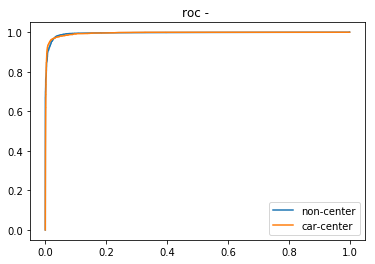

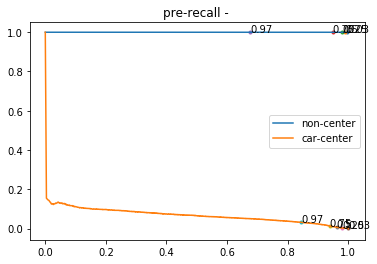

In [5]:
# eval with no post-process (baseline)

print('TF')
start = time.time()
metric.evaluate_model(model_func=pred_func,
                      input_label_itr=dataset.iterate_data_file)
print('used time %.5fs' % (time.time()-start))
metric.print_result()
metric.plot_cur_epoch_curve(show=True, save_path=None)
metric.clear_cur_epoch()

In [4]:
# define post-process

idx_list = np.meshgrid(np.arange(60), np.arange(80), indexing='ij')
idx_list[0] = idx_list[0].flatten()
idx_list[1] = idx_list[1].flatten()
def get_dbscan_rst(img_prob, arg=[0.8, 5, 20, '']):
    canvas_list = []
    for cur_prob in img_prob:
        data_arr = []
        selected_idx = []
        for i,j,prob in zip(*idx_list, img_prob.squeeze().reshape(-1,2)):
            if prob[1] > arg[0]:
                data_arr.append([i,j,*prob])
                selected_idx.append([i,j])

        canvas = np.zeros(img_prob.squeeze().shape[:-1])
        
        if data_arr: # process if any data selected
            data_arr = np.array(data_arr)
            selected_idx = np.array(selected_idx)
            dbscan = skcl.DBSCAN(arg[1], arg[2])

            if arg[-1] == 'm':
                data_arr = data_arr - data_arr.mean(axis=0)
            elif arg[-1] == 's':
                data_arr = data_arr - data_arr.mean(axis=0)
                data_arr = data_arr / data_arr.std(axis=0)

            dbscan_rst = dbscan.fit_predict(data_arr)
            for c in set(dbscan_rst):
                if c == -1: continue
                mean = selected_idx[np.where(dbscan_rst == c)].mean(axis=0).round().astype(int)
                canvas[mean[0], mean[1]] = 1

        canvas_list.append(canvas)
    return np.array(canvas_list)

def sk_dbscan(data_arr, prob_arr, arg=[0.5, 5, 20, '']):
    selected_arr = data_arr[np.where(prob_arr[:,1]>arg[0])].copy()
    dbscan = skcl.DBSCAN(arg[1], arg[2])
    
    if selected_arr.size > 0:
        if arg[-1] == 'm':
            selected_arr = selected_arr - selected_arr.mean(axis=0)
        elif arg[-1] == 's':
            selected_arr = selected_arr - selected_arr.mean(axis=0)
            selected_arr = selected_arr / selected_arr.std(axis=0)
        dbscan_rst = dbscan.fit_predict(selected_arr)

        mean_list = [selected_arr[np.where(dbscan_rst == c)].mean(axis=0) for c in set(dbscan_rst) if c != -1]
    else:
        mean_list = []
        
    return mean_list

def sk_affinity_propa(data_arr, prob_arr, arg=[0.5, 0.5, '']):
    selected_arr = data_arr[np.where(prob_arr[:,1]>arg[0])].copy()
    ap = skcl.AffinityPropagation(damping=arg[1])
    
    if selected_arr.size > 0:
        if arg[-1] == 'm':
            selected_arr = selected_arr - selected_arr.mean(axis=0)
        elif arg[-1] == 's':
            selected_arr = selected_arr - selected_arr.mean(axis=0)
            selected_arr = selected_arr / selected_arr.std(axis=0)
        ap_rst = ap.fit_predict(selected_arr)

        mean_list = [selected_arr[np.where(ap_rst == c)].mean(axis=0) for c in set(ap_rst) if c != -1]
    else:
        mean_list = []
    print(mean_list)
    return mean_list


def get_crf_rst(image, pred, compat=[0.4,-0.5]):
    softmax = pred.squeeze().transpose((2, 0, 1))

    # The inputs should be C-continious -- we are passing array into C via Cython wrapper
    unary = dcrf.utils.unary_from_softmax(softmax)
    unary = np.ascontiguousarray(unary)

    # This potential penalizes small pieces of segmentation that are
    # spatially isolated -- enforces more spatially consistent segmentations
    g_feats = dcrf.utils.create_pairwise_gaussian(sdims=(1, 1), shape=image.shape[:-1])

    # This creates the color-dependent features --
    # use local color features to refine coarse segmentation from CNN
    # chdim denote the color channel, with -1 as no color channel (grey scale)
    bi_feats = dcrf.utils.create_pairwise_bilateral(sdims=(1, 1), schan=(1, 1, 1), img=image, chdim=2)

    d = dcrf.densecrf.DenseCRF2D(image.shape[0], image.shape[1], class_num)
    d.setUnaryEnergy(unary)
    # compat is the "strength" of this potential.
    d.addPairwiseEnergy(g_feats, compat=compat[0],
                        kernel=dcrf.densecrf.DIAG_KERNEL, normalization=dcrf.densecrf.NORMALIZE_SYMMETRIC)
    d.addPairwiseEnergy(bi_feats, compat=compat[1],
                         kernel=dcrf.densecrf.DIAG_KERNEL, normalization=dcrf.densecrf.NORMALIZE_SYMMETRIC)
    
    Q = d.inference(10)
    res = np.array(Q).reshape((-1,image.shape[0], image.shape[1])).transpose(1,2,0)
    return res

def cmp_rst(mask, *args):
    plt.close('all')
    img_num = len(args) + 1
    f, axs = plt.subplots(1, img_num, sharey=True, figsize=(img_num*10,8))
    
    for ax, img in zip(axs[:-1], args):
        im = ax.imshow(img, vmax=1, vmin=0)
        f.colorbar(im, ax=ax)
        
    im = axs[-1].imshow(mask, vmax=1, vmin=0)
    f.colorbar(im, ax=axs[-1])
    axs[-1].set_title('mask')
    plt.show()

In [5]:
cur_md['pred_prob']

<function Model_Analyzer.Loader.Project_Loader._load_model.<locals>.<lambda>(x, md=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False), cols=[2, 3, 4, 5, 6, 7, 8, 9])>

0.15
('../../Data/corner/dw_19991231_163008_0.000000_0.000000/radar_file', 'dw_19991231_163008_000000002.csv')


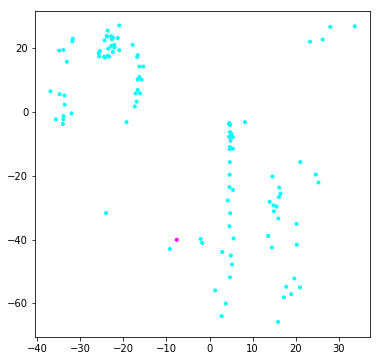


0.1375
('../../Data/corner/dw_19991231_163008_0.000000_0.000000/radar_file', 'dw_19991231_163008_000000004.csv')


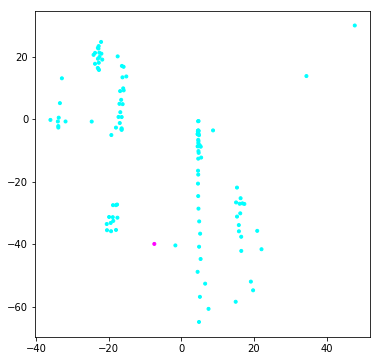


0.0875
('../../Data/corner/dw_19991231_163008_0.000000_0.000000/radar_file', 'dw_19991231_163008_000000005.csv')


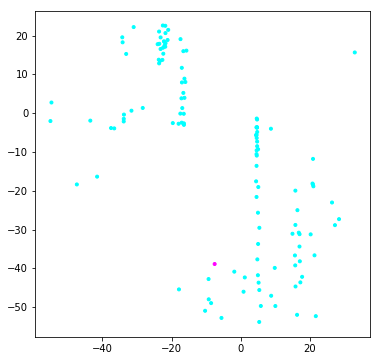


0.1875
('../../Data/corner/dw_19991231_163008_0.000000_0.000000/radar_file', 'dw_19991231_163008_000000007.csv')


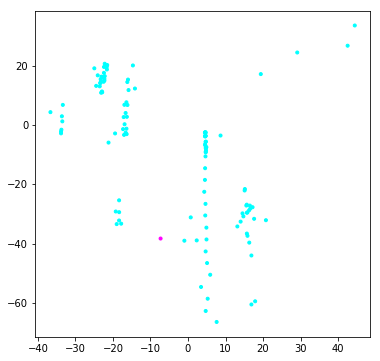


0.1625
('../../Data/corner/dw_19991231_163008_0.000000_0.000000/radar_file', 'dw_19991231_163008_000000008.csv')


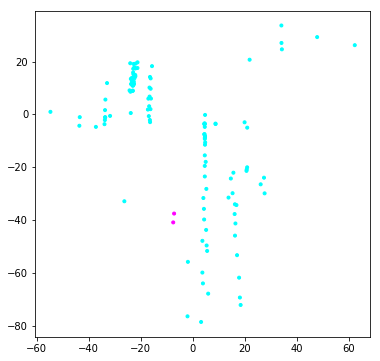


0.2125
('../../Data/corner/dw_19991231_163008_0.000000_0.000000/radar_file', 'dw_19991231_163008_000000010.csv')


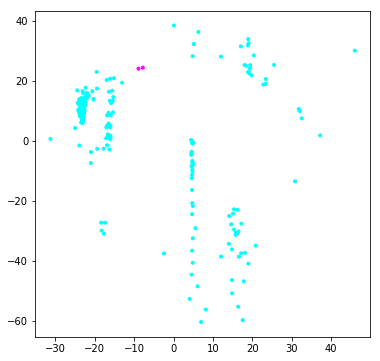


0.1875
('../../Data/corner/dw_19991231_163008_0.000000_0.000000/radar_file', 'dw_19991231_163008_000000011.csv')


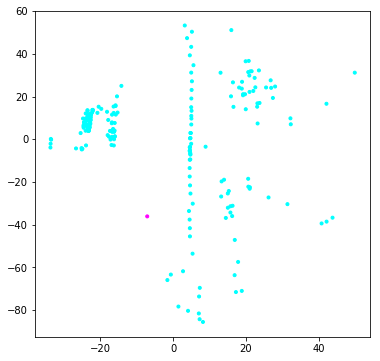


0.15
('../../Data/corner/dw_19991231_163008_0.000000_0.000000/radar_file', 'dw_19991231_163008_000000013.csv')


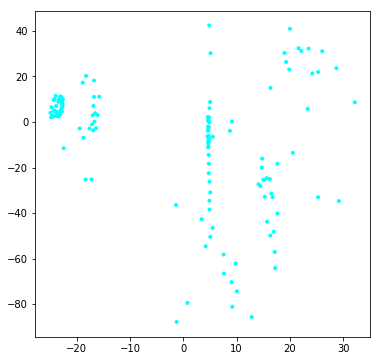


0.0875
('../../Data/corner/dw_19991231_163008_0.000000_0.000000/radar_file', 'dw_19991231_163008_000000014.csv')


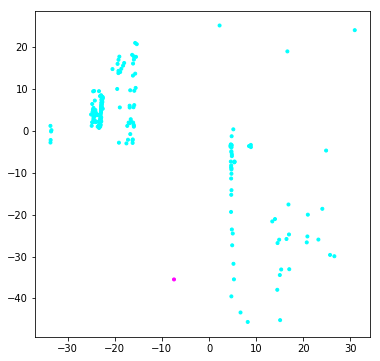


0.0625
('../../Data/corner/dw_19991231_163008_0.000000_0.000000/radar_file', 'dw_19991231_163008_000000016.csv')


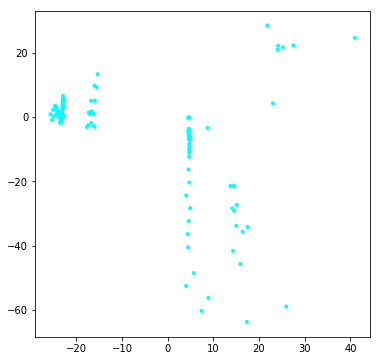


0.125
('../../Data/corner/dw_19991231_163008_0.000000_0.000000/radar_file', 'dw_19991231_163008_000000017.csv')


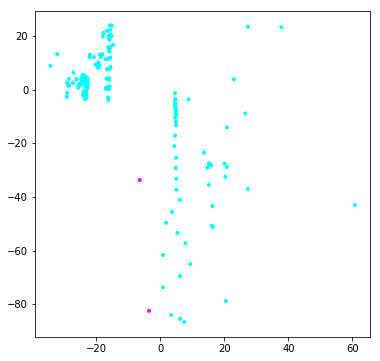


0.1625
('../../Data/corner/dw_19991231_163008_0.000000_0.000000/radar_file', 'dw_19991231_163008_000000019.csv')


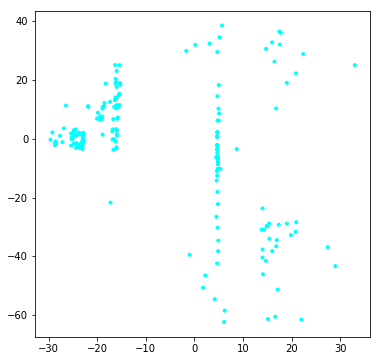


0.2375
('../../Data/corner/dw_19991231_163008_0.000000_0.000000/radar_file', 'dw_19991231_163008_000000020.csv')


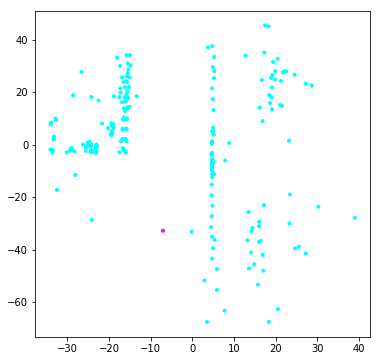

KeyboardInterrupt: 

In [16]:
for (input_arr, label), fname in zip(dataset.iterate_data_file(), dataset.traverser.path_list):
    if '162610' in fname[0]: continue
    prob_arr = cur_md['pred_prob'](input_arr)
    print(prob_arr[:,1].max())
    data_arr = np.concatenate([input_arr[:,[2,3]], prob_arr])
    
#     rst = sk_dbscan(data_arr, prob_arr, arg=[0.3, 10, 0, ''])
#     rst = sk_affinity_propa(data_arr, prob_arr, arg=[0.4, 0.1, ''])
#     rst = np.array(skdbscan_rst)

    rst = input_arr[np.where(prob_arr[:,1] > prob_arr[:,0])][:,[2,3]]

    print(fname)
    plt.figure(figsize=(6,6))
    plt.scatter(-input_arr[:,3], input_arr[:,2], c=label[:,1], marker='.', cmap='cool')
    for center in rst:
        circle = plt.Circle((-center[1], center[0]), radius=2, color='r', fill=False)
        plt.gcf().gca().add_artist(circle)
    plt.show()
    input()

In [6]:
# post-process result vis compare

dataset.traverser.path_list = sorted(dataset.traverser.path_list)
for (img_input, img_mask), path in zip(dataset.iterate_data_file(), dataset.traverser.path_list):
    tf_rst = cur_tf['pred_prob'](img_input)

    crf_rst = get_crf_rst(img_input, tf_rst).squeeze()[...,-1]
    dbscan_rst = get_dbscan_rst(tf_rst).squeeze()

    tf_rst = tf_rst.squeeze()[...,-1]
    
    input_mask = np.ones(img_input.shape)
    input_mask[np.where(img_input[...,0]==1)] = 0

    
    print(path)
    cmp_rst(img_mask[...,1], tf_rst, crf_rst, dbscan_rst)
    input()

NameError: name 'cur_tf' is not defined

In [27]:
np.arange(len(dbscan_rst.flatten()))

array([   0,    1,    2, ..., 4797, 4798, 4799])

[0.1934378790362079, -0.41392555738114517]
[1.4790229966273394, -0.6331312962285329]
[0.6000612808085625, -0.6665800813863745]
[-0.024664468020335728, 0.3774340374193046]
[0.6864419326953203, 0.6571972449068402]
CRF:	[0.1934378790362079, -0.41392555738114517]
used time 973.78895s
mean_loss =  0.0 overall balanced_acc =  0.9715258383984029 
balanced_acc =  ['non-center : 0.9715258383984029', 'car-center : 0.9715258383984029'] 
auc =  ['non-center : 0.9952442591696393', 'car-center : 0.9952442576235712'] 
avg_precision =  ['non-center : 0.9999992958965418', 'car-center : 0.06414115666198528']
max pred matrix:
          	non-center	car-center
non-center	35451563	716176
car-center	188	4873
mean prob matrix:
          	non-center	car-center
non-center	0.9422294358500476	0.05763065212485359
car-center	6.74195273394556e-06	0.0001331698040583398


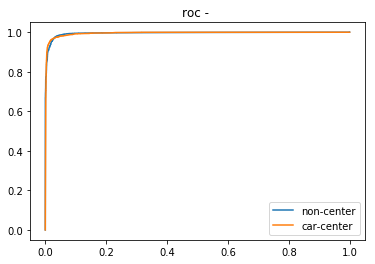

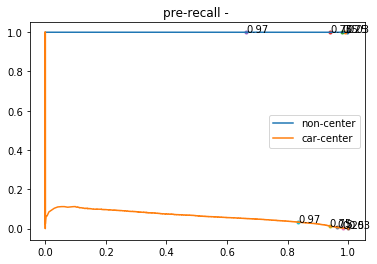

CRF:	[1.4790229966273394, -0.6331312962285329]
used time 979.41209s
mean_loss =  0.0 overall balanced_acc =  0.9707359233660262 
balanced_acc =  ['non-center : 0.9707359233660262', 'car-center : 0.9707359233660262'] 
auc =  ['non-center : 0.9953218452476946', 'car-center : 0.9953218673897991'] 
avg_precision =  ['non-center : 0.9999993093263438', 'car-center : 0.06533721377741764']
max pred matrix:
          	non-center	car-center
non-center	35530205	637534
car-center	207	4854
mean prob matrix:
          	non-center	car-center
non-center	0.9628854359939699	0.03697465227105275
car-center	6.7508583688159585e-06	0.00013316089845176996


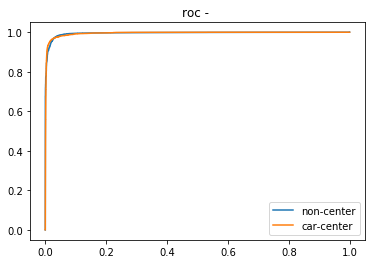

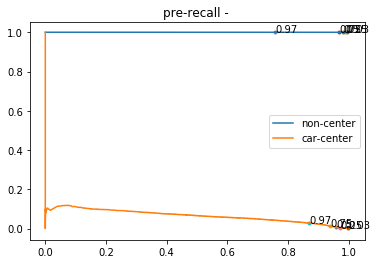

CRF:	[0.6000612808085625, -0.6665800813863745]
used time 973.65413s
mean_loss =  0.0 overall balanced_acc =  0.9715794861785229 
balanced_acc =  ['non-center : 0.971579472354048', 'car-center : 0.9715794861785229'] 
auc =  ['non-center : 0.9952672294347381', 'car-center : 0.9952672523963149'] 
avg_precision =  ['non-center : 0.9999992998911258', 'car-center : 0.06449473007324574']
max pred matrix:
          	non-center	car-center
non-center	35462590	705149
car-center	189	4872
mean prob matrix:
          	non-center	car-center
non-center	0.9455789366719249	0.05428115100112377
car-center	6.718295293238203e-06	0.00013319346155099557


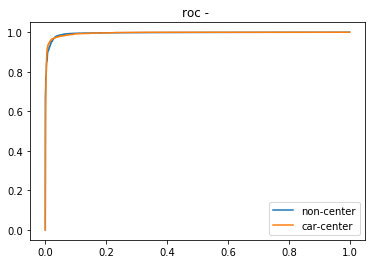

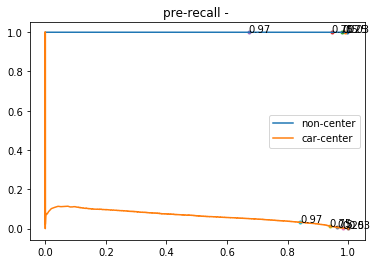

CRF:	[-0.024664468020335728, 0.3774340374193046]
used time 976.50629s
mean_loss =  0.0 overall balanced_acc =  0.971027383352661 
balanced_acc =  ['non-center : 0.971027383352661', 'car-center : 0.971027383352661'] 
auc =  ['non-center : 0.9952787338917782', 'car-center : 0.9952787259565679'] 
avg_precision =  ['non-center : 0.999999301692506', 'car-center : 0.0655712242048205']
max pred matrix:
          	non-center	car-center
non-center	35494117	673622
car-center	199	4862
mean prob matrix:
          	non-center	car-center
non-center	0.9540981962402537	0.0457618902081372
car-center	6.669084011391991e-06	0.00013324267267356168


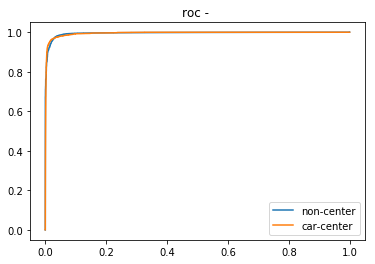

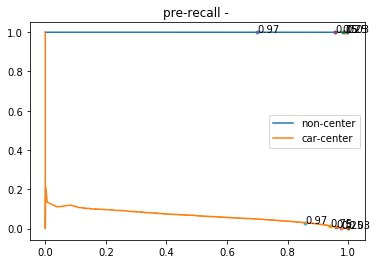

CRF:	[0.6864419326953203, 0.6571972449068402]
used time 972.77947s
mean_loss =  0.0 overall balanced_acc =  0.9696706812879661 
balanced_acc =  ['non-center : 0.9696706812879661', 'car-center : 0.9696706812879661'] 
auc =  ['non-center : 0.9953125776950393', 'car-center : 0.995312557465033'] 
avg_precision =  ['non-center : 0.9999993082602507', 'car-center : 0.06581790458211054']
max pred matrix:
          	non-center	car-center
non-center	35567492	600247
car-center	223	4838
mean prob matrix:
          	non-center	car-center
non-center	0.9700162470124594	0.02984383666556917
car-center	6.897849327686124e-06	0.00013301390736244825


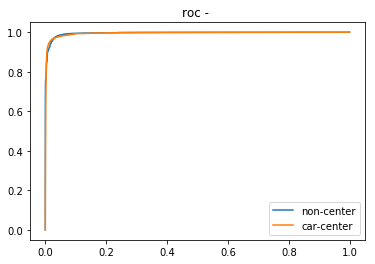

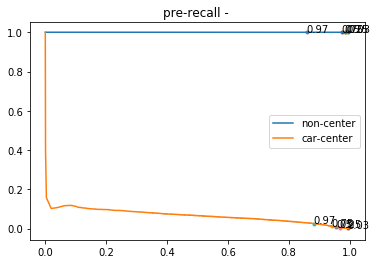

In [8]:
# CRF-inference tuning

compat_list = [list(np.random.randn(2) * 0.5 + [0.4, -0.5]) for i in range(5)]
print('\n'.join([str(i) for i in compat_list]))

for compat in compat_list:
    print('CRF:\t%s' % (str(compat)))
    crf_pred_func = lambda x, y, c=compat: (get_crf_rst(x, cur_tf['pred_prob'](x), c), 0)

    metric = analyzer.General_Mertic_Record(class_num=class_num, class_name=['non-center','car-center'])
    gc.collect()
    
    start = time.time()
    metric.evaluate_model(model_func=crf_pred_func,
                          input_label_itr=dataset.iterate_data_file)
    print('used time %.5fs' % (time.time()-start))
    metric.print_result()
    metric.plot_cur_epoch_curve(show=True, save_path=None)

pred_thr, eps, min_sample, normtype
[0.8, 5, 20, '']
DBSCAN:	[0.8, 5, 20, '']
used time 1237.20324s
mean_loss =  0.0 overall balanced_acc =  0.5 
balanced_acc =  ['non-center : 0.5', 'car-center : 0.7247561659124497'] 
auc =  ['non-center : 0.5', 'car-center : 0.7247561659124497'] 
avg_precision =  ['non-center : 0.9998600882430998', 'car-center : 0.0002631147032531864']
max pred matrix:
          	non-center	car-center
non-center	36167739	0
car-center	5061	0
mean prob matrix:
          	non-center	car-center
non-center	0.9998600882430998	0.46842251636588816
car-center	0.00013991175690021232	0.0001284390481245577


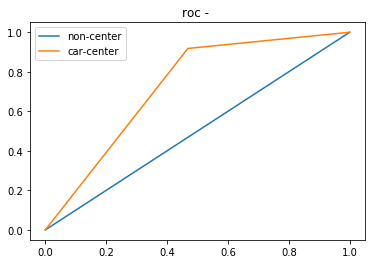

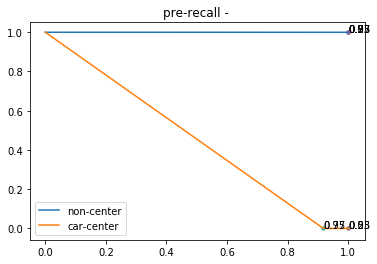

In [31]:
# DBSCAN tuning

arg_list = [[0.8, 5, 20, '']]
print('pred_thr, eps, min_sample, normtype')
print('\n'.join([str(i) for i in arg_list]))

for arg in arg_list:
    print('DBSCAN:\t%s' % (str(arg)))
    metric = analyzer.General_Mertic_Record(class_num=class_num, class_name=['non-center','car-center'])
    dbscan_pred_func = lambda x, y, c=arg: (metric._to_onehot(get_dbscan_rst(cur_tf['pred_prob'](x), arg).reshape(-1, 1).astype(int)), 0)

    gc.collect()
    
    start = time.time()
    metric.evaluate_model(model_func=dbscan_pred_func,
                          input_label_itr=dataset.iterate_data_file)
    print('used time %.5fs' % (time.time()-start))
    metric.print_result()
    metric.plot_cur_epoch_curve(show=True, save_path=None)

In [10]:
# predict (model should already be loaded by now)

def tf_cluster_pred_func(x):
    rst =  get_dbscan_rst(cur_tf['pred_prob'](x))
    rst = dataset._to_onehot(rst.flatten().astype(int)).reshape(*rst.shape, -1)
    return rst

def sk_cluster_pred_func(x):
    if x.size > 0:
        prob_arr = cur_md['pred_prob'](x)
        data_arr = np.concatenate([x[:,[2,3]], prob_arr])
        rst = np.array(sk_dbscan(data_arr, prob_arr, arg=[0.5, 10, 1, '']))
    else:
        rst = np.array([])
    return rst

def sk_raw_pred_func(x):
    if x.size > 0:
        xy_arr = x[:,[2,3]]
        prob_arr = cur_md['pred_prob'](x)

        rst = xy_arr[np.where(prob_arr[:,1] > prob_arr[:,0])]
    else:
        rst = np.array([])
    return rst

pred_opt = {'pred_type': 'protobuf',
            'protobuf_path': '../../../radarfusion/radar-data-processing/scripts',
            'proto_post': '-sk.prototxt'}
project.feeder.traverser.path_list = sorted(project.feeder.traverser.path_list)
project.feeder.record_prediction(pred_func=sk_raw_pred_func,
                                 model_name=cur_md['info'].name,
                                 output_dir='./Prediction',
                                 dataset_name=project.dataset_name,
                                 overwrite=True,
                                 options=pred_opt)

In [17]:
cur_md['pred_prob']

<function Model_Analyzer.Loader.Project_Loader._load_model.<locals>.<lambda>(x, md=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False), cols=[2, 3, 4, 5, 6, 7, 8, 9])>

In [9]:
def record_prediction(pred_func, model_name, 
                      output_dir='./Prediction', dataset_name='Data', overwrite=False, 
                      options={'pred_type': 'csv', 
                               'protobuf_path': '../../Data/corner/evaluate-test',
                               'proto_post': '.prototxt'},
                     self=project.feeder):
    '''
    extended to accomodate protobuf
    '''
    self.pred_opt = options
    pred_type = options['pred_type']
    if pred_type == 'protobuf':
        self._write_pred_to_file = self._write_pred_to_protobuf
        sys.path.append(options['protobuf_path'])
        self.pred_opt['rsds_data_pb2'] = __import__('rsds_data_pb2', fromlist=[''])
        self.pred_opt['proto_post'] = options['proto_post']
    else: # default to csv
        self._write_pred_to_file = self._write_pred_to_csv

    return feeder.Gen_Feeder.record_prediction(self, pred_func, model_name,
                                        output_dir=output_dir,
                                        dataset_name=dataset_name,
                                        overwrite=overwrite)

def _record_pred(data_dirpath, data_name, pred_func, model_name, out_subdir, overwrite, self=project.feeder):
    _, cur_input = self._get_input(data_dirpath, data_name)
    cur_pred = pred_func(cur_input) # assume 1 img per batch
    
    pred_center_list = [[-c[1], c[0]] for c in cur_pred]
    self._write_pred_to_file(pred_center_list, model_name, data_name, out_subdir, overwrite)

def _write_pred_to_protobuf(pred_center_list, model_name, data_name, out_subdir, overwrite, self=project.feeder):
    default_size = self.resolution
    assert overwrite

    rst = self.pred_opt['rsds_data_pb2'].RsdsResults()
    for [cart_x, cart_y] in pred_center_list:
        t = rst.targets.add()
        # invalide value for required fields
        t.group_id = -1 
        t.track_id = -1
        # fill according to test_rsds.py, test plt & protobuf coord is NOT in cartesian coord)
        t.coord_x = cart_y
        t.coord_y = -cart_x
        t.size_x = default_size
        t.size_y = default_size
    with open(os.path.join(out_subdir, data_name.replace('.csv', self.pred_opt['proto_post'])), 'wb') as f:
        f.write(rst.SerializeToString())
    return

project.feeder.resolution              = 0.5
project.feeder._record_pred            = _record_pred
project.feeder.record_prediction       = record_prediction
project.feeder._write_pred_to_protobuf = _write_pred_to_protobuf

In [26]:
a = np.array([])
a.size

0